### Try to find a way to compute the synchrony of neurons accross time

In [19]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
%matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'

# import basefunction.anass_load as at

In [3]:
# def binEdges2centers(BinEdges):
#     #Vitor Code (Thanks)
#     BinCenters = np.convolve(BinEdges,[.5,.5],'same')
#     BinCenters = BinCenters[1::]

#     return BinCenters

In [4]:
# def synchrony(neurons,metadata,binSize,stru,sm = 201,method = 'corr',plot = True):
#     #Old version, please refer to below
#     try: bk.load.session
#     except NameError: bk.load.session = None
    
# #     binSize = 0.1
#     winSize = int(1/binSize)
#     step = int(1/binSize)

    
#     print(len(neurons))
#     print(binSize)
    

#     binned,t = binSpikes(neurons,binSize)
    
#     stru_shank = {}
#     stru_mask  = {}
    
#     for s in stru:
#             stru_shank.update({s:at.get_structure_shanks(bk.load.session,s)})
#             if not np.any(stru_shank[s]):
#                 print('Could not compute ' + s + ' because is you don\'t have shank in it')
#                 continue
#             stru_mask.update({s:[i in stru_shank[s] for i in metadata[:,0]]})
    
#     if method == 'corr':
#         pbar = ProgressBar()
#         corr = np.empty((int(binned.shape[1]/step)+1,len(neurons),len(neurons)))   

#         for i,j in enumerate(pbar(range(0,binned.shape[1],step))):
#             corr[i] = np.corrcoef(binned[:,j:j+winSize])
#             corr[i][np.isnan(corr[i])] = 0
#         t = t[::step]
#         # corr = np.abs(corr)

#         stru_corr  = {}
#         stru_sync  = {}
            
#         for s in stru_mask.keys():
#             print('computing '+s)
#             stru_corr.update({s:corr[:,:,stru_mask[s]][:,stru_mask[s]]})
#             stru_sync.update({s:np.nanmean(stru_corr[s],axis = (1,2))})

#         stru_corr.update({'Hpc-BLA':corr[:,:,stru_mask['Hpc']][:,stru_mask['BLA']]})
#         stru_sync.update({'Hpc-BLA':np.nanmean(stru_corr['Hpc-BLA'],axis = (1,2))})

#         # for s,s2 in itertools.combinations(stru_mask.keys(),2):
#         #     print('computing '+s+'-'+s2)
#         #     stru_corr.update({s+'-'+s2:corr[:,:,stru_mask[s]][:,stru_mask[s2]]})
#         #     stru_sync.update({s+'-'+s2:np.nanmean(stru_corr[s+'-'+s2],axis = (1,2))})

#     elif method == 'coactivation':
#         #Binarize the binning.
#         #count number of cell active at each timebin
#         # nb of cell active / total number in da category for each time point. 
    
#         binarize_binned = np.where(binned<1,binned,1)
#         stru_sync  = {}
#         for s in stru_mask.keys():
#             print('computing '+s)
#             stru_sync.update({s:np.sum(binarize_binned[stru_mask[s],:],0)/binarize_binned.shape[0]})
            
#     elif method == 'firing':
#         stru_sync  = {}
#         for s in stru_mask.keys():
#             print('computing '+s)
#             stru_sync.update({s:np.mean(binned[stru_mask[s],:],0)/binSize})
#     else:    

#         print(method + ' Is an unknown method')
#         raise ValueError('Unknow Method')
    
    
#     if plot:
#         for s in stru_sync:
#             plt.plot(t,savgol_filter(stru_sync[s],sm,3))
#         plt.title('synchrony during ' + bk.session)
#         plt.legend([s for s in stru_sync.keys()])
#         plt.ylabel('r')
#         plt.xlabel('Time(s)')

#         Rem = nts.IntervalSet(scipy.io.loadmat('States.mat')['Rem'][:,0],scipy.io.loadmat('States.mat')['Rem'][:,1],time_units = 's')
#         plotIntervals(Rem,'darkorange')

#         sws = nts.IntervalSet(scipy.io.loadmat('States.mat')['sws'][:,0],scipy.io.loadmat('States.mat')['sws'][:,1],time_units = 's')
#         plotIntervals(sws,'grey')
    
#     return stru_sync

# def binSpikes(neurons,binSize = 0.05,start = 0,stop = 0):
#     if stop == 0:
#         stop = np.max([neuron.as_units('s').index[-1] for neuron in neurons])

#     bins = np.arange(start,stop,binSize)
#     binned = []
#     for neuron in neurons:
#         hist,b = np.histogram(neuron.as_units('s').index,bins = bins)
#         binned.append(hist)

#     return np.array(binned), binEdges2centers(b)

# def plotIntervals(intervals,col):
#     for interval in intervals.as_units('s').values:
#         plt.axvspan(interval[0],interval[1], facecolor=col, alpha=0.5)

In [22]:
def synchrony(neurons,binSize,winSize,step,sm = 201,method = 'corr',plot = True):
    try: bk.load.session
    except NameError : bk.load.session = None
    
    winSize = int(winSize / binSize)
    step = int(step/binSize)
    print('Computing synchrony with following parameters')
    print('winSize (bins) : ',winSize*2)
    print('Step    (bins) : ',step)
    print(len(neurons),' neurons')
    t,binned = bk.compute.binSpikes(neurons,binSize)
    
    if method.lower() == 'corr':
        
        #Don't really why, but it's working this way ... 
        corr_sample = binned.shape[1]/step
        if not corr_sample.is_integer(): 
            corr_sample = int(corr_sample)+1
        else:
            corr_sample = int(corr_sample)
            
        corr = np.zeros(corr_sample)
        for i,j in enumerate(tqdm(range(0,binned.shape[1],step))):
            
            corr_mat = np.corrcoef(binned[:,j-winSize:j+winSize])
#             corr_mat[np.isnan(corr_mat)] = 0
            corr[i] = np.nanmean(corr_mat)
        t = t[::step]
        
        corr = nts.Tsd(t,corr,time_units = 's')
        return corr

def average_over_transitions(signal,nBins,intervals,timing,states):
    if len(intervals) < 4: return 0
    
    c_all = []
    pre_all = []
    post_all = []
    
    for event,t in zip(intervals.iloc,timing.index.values):
        pre = nts.IntervalSet(event[0],t)
        post = nts.IntervalSet(t,event[1])
        event = nts.IntervalSet(event[0],event[1])

        if pre.tot_length(time_units = 's') < 150: continue
        if post.tot_length(time_units = 's') < 50: continue
        
        s = signal.restrict(event)
        s.index = s.index-t
        s_pre = signal.restrict(pre)
        s_post = signal.restrict(post)
        
        plt.plot(s.as_units('s')[-150:50],'grey',alpha = 0.1)
        c_all.append(s.as_units('s')[-150:50])
        pre_all.append(np.mean(s.as_units('s')[-150:0].values)) 
        post_all.append(np.mean(s.as_units('s')[0:50].values))
        
    c_all = np.array(c_all)
    c_all_ave = nts.Tsd(s.as_units('s')[-150:50].index.values*1_000_000,np.nanmean(c_all,0))
    
    plt.axvline(0,color = 'red')
    plt.axvspan(0,50,facecolor = 'orange',alpha = 0.5)
    plt.plot(c_all_ave.as_units('s'))
    print(c_all.shape)
    print(np.nanmean(np.array([pre_all,post_all]),1))
    
    return c_all

In [25]:
def main(path):
    
    binSize = 0.100
    winSize = 0.5
    step = 1
    
#     bk.load.current_session(path)
#     bk.load.
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    stru = metadata.Region.unique()
    stru = np.delete(stru,stru == 'None')
    
    transitions = bk.compute.transitions_times(states)
    fig = plt.figure()
    c_all = {}
#     fig,ax = plt.subplots(len(stru),sharex = True)
    plt.suptitle(f'{bk.load.session} \nbin = {binSize}s + win = {winSize*2}s + step = {step}s')
    for i,s in enumerate(stru,0):
        plt.subplot(4,1,i+1)

        t = 'Pyr'
        nNeurons = len(neurons[(metadata.Region == s) & (metadata.Type == t)])
        print(s,t)
        c = synchrony(neurons[(metadata.Region == s) & (metadata.Type == t)],binSize = binSize,winSize = winSize,step = step)
#         c_sm = bk.compute.nts_smooth(c,100,50)
#         plt.subplot(len(stru),1,i+1)
        plt.title(f'{s} + {t} - #{nNeurons}')
        average = average_over_transitions(c,[30,12],transitions[0][('sws', 'Rem')],transitions[1][('sws', 'Rem')],states)
        c_all.update({s:average})
        
    
#         plt.plot(c.as_units('s'),alpha = 0.5)
#         plt.plot(bk.compute.nts_smooth(c,1000,5).as_units('s'),'-r')

#         bk.plot.intervals(states['Rem'],'orange')
#         bk.plot.intervals(states['sws'],'grey')
#         plt.xlim([0,5000])

        #     c = nts.Tsd(c.index.values,np.convolve(c.values,g,'same'))
    #     plt.plot(bk.compute.nts_smooth(c,100,).as_units('s'))
    # bk.plot.intervals(states['Rem'],'orange')
    # bk.plot.intervals(states['sws'],'grey')
    return c_all

In [26]:
main("/media/billel/GGLab-01-BK/DATA/Rat08-20130713")

Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Hpc Pyr
Computing synchrony with following parameters
winSize (bins) :  10
Step    (bins) :  10
55  neurons


  0%|          | 0/22680 [00:00<?, ?it/s]/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/billel/a

(15, 200)
[0.11239004 0.118441  ]
BLA Pyr
Computing synchrony with following parameters
winSize (bins) :  10
Step    (bins) :  10
83  neurons


  0%|          | 0/22680 [00:00<?, ?it/s]

(15, 200)
[0.06038546 0.0509599 ]
VEn Pyr
Computing synchrony with following parameters
winSize (bins) :  10
Step    (bins) :  10
19  neurons


100%|██████████| 22680/22680 [00:04<00:00, 5467.85it/s]


(15, 200)
[0.26943888 0.21421007]
Pir Pyr
Computing synchrony with following parameters
winSize (bins) :  10
Step    (bins) :  10
66  neurons


100%|██████████| 22680/22680 [00:05<00:00, 4381.03it/s]


(15, 200)
[0.07887587 0.04769739]


{'Hpc': array([[0.13717421, 0.05491506, 0.09969835, ..., 0.18462092, 0.06323163,
         0.09358642],
        [0.04957992, 0.0592092 , 0.04951789, ..., 0.07906056, 0.03815398,
         0.11564147],
        [0.10501423, 0.1533512 , 0.15505945, ..., 0.09606634, 0.07460801,
         0.10865965],
        ...,
        [0.05040707, 0.04596446, 0.05762966, ..., 0.02385195, 0.03881707,
         0.03313957],
        [0.44444444, 0.1074028 , 0.11522383, ..., 0.17831583, 0.05385097,
         0.05808607],
        [0.21568386, 0.24107399, 0.61749014, ..., 0.04154549, 0.10910369,
         0.09287704]]),
 'BLA': array([[0.05293537, 0.05673376, 0.07126266, ..., 0.03100573, 0.01587059,
         0.05378314],
        [0.05013677, 0.03730312, 0.05734266, ..., 0.03070006, 0.02988994,
         0.04857791],
        [0.06277303, 0.03639846, 0.04776585, ..., 0.03044925, 0.02651958,
         0.05200758],
        ...,
        [0.17198813, 0.02230017, 0.04351744, ..., 0.02397052, 0.05955433,
         0.03613211]

In [8]:
path = '/media/billel/GGLab-01-BK/DATA/Rat08-20130713/'
os.chdir(path)
bk.load.path = path
bk.load.rat = 8
bk.load.session = 'Rat08-20130713'
bk.load.day = 6

binSize = 0.025
winSize = 2
step = 1

#     bk.load.current_session(path)
#     bk.load.
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
states = bk.load.states()
stru = metadata.Region.unique()
stru = np.delete(stru,stru == 'None')

transitions = bk.compute.transitions_times(states)
fig = plt.figure()
c_all = {}
fig,ax = plt.subplots(len(stru),sharex = True)
plt.suptitle(f'{bk.load.session} \nbin = {binSize}s + win = {winSize*2}s + step = {step}s')



Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


Text(0.5, 0.98, 'Rat08-20130713 \nbin = 0.025s + win = 4s + step = 1s')

In [11]:
stru = ['Hpc','BLA']
for i,s in enumerate(stru):
    t = 'Pyr'
    c = synchrony(neurons[(metadata.Region == s) & (metadata.Type == t)],binSize = binSize,winSize = winSize,step = step)
    c_sm = bk.compute.nts_smooth(c,100,10)
    plt.plot(c_sm.as_units('s'))
bk.plot.intervals(states['Rem'],col = 'orange')
bk.plot.intervals(states['sws'],col = 'grey')

Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
55  neurons


  0%|          | 0/22680 [00:00<?, ?it/s]/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/billel/a

Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
83  neurons


100%|██████████| 22680/22680 [00:08<00:00, 2753.18it/s]


In [7]:
for i,s in enumerate(stru,0):
    t = 'Pyr'
    nNeurons = len(neurons[(metadata.Region == s) & (metadata.Type == t)])
    print(s,t)
    n = neurons[(metadata.Region == s) & (metadata.Type == t)]
    c = synchrony(neurons[(metadata.Region == s) & (metadata.Type == t)],binSize = binSize,winSize = winSize,step = step)
    c_sm = bk.compute.nts_smooth(c,90,25)
    plt.subplot(len(stru),1,i+1)
    plt.title(f'{s} + {t} - #{nNeurons}')
#     average = average_over_transitions(c,[30,12],transitions[0][('sws', 'Rem')],transitions[1][('sws', 'Rem')],states)
#         c_all.update({s:average})

#     plt.plot(c.as_units('s'),alpha = 0.5)
    plt.plot(bk.compute.nts_smooth(c,20,5).as_units('s'),'-r')
    bk.plot.intervals(states['Rem'],'orange')
    bk.plot.intervals(states['sws'],'grey')
    plt.xlim([0,5000])

Hpc Pyr
Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
55  neurons


  0%|          | 0/22680 [00:00<?, ?it/s]/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/billel/a

[0.0424411  0.05091746]
BLA Pyr
Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
83  neurons


100%|██████████| 22680/22680 [00:07<00:00, 3071.97it/s]


[0.02495103 0.02515088]
VEn Pyr
Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
19  neurons


100%|██████████| 22680/22680 [00:04<00:00, 5019.52it/s]


[0.0953392  0.09324396]
Pir Pyr
Computing synchrony with following parameters
winSize (bins) :  160
Step    (bins) :  40
66  neurons


100%|██████████| 22680/22680 [00:05<00:00, 3807.93it/s]


[0.0281968  0.02350075]


In [4]:
main('Z:\Rat08\Rat08-20130713')

FileNotFoundError: [Errno 2] No such file or directory: 'Z:/All-Rats/Billel/session_indexing.csv'

In [6]:
batch = bk.load.batch(main)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [17:36<00:00, 17.31s/it]

Batch finished in 1056.1053953170776
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat10-20140702', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313']
9.836065573770492 %


In [ ]:
path = '/media/billel/GGLab-01-BK/DATA/Rat08-20130713/'
os.chdir(path)
bk.load.path = path
bk.load.rat = 8
bk.load.session = 'Rat08-20130713'
bk.load.day = 6

In [8]:
neurons,metadata = bk.load.loadSpikeData(bk.load.path)

AttributeError: module 'bk.load' has no attribute 'path'

In [9]:
interval = nts.IntervalSet(1250,1251,time_units='s')

In [10]:
for i,n in enumerate(neurons):
    neurons[i] = n.restrict(interval)

NameError: name 'neurons' is not defined

In [111]:
t,b = bk.compute.binSpikes(neurons,binSize= 0.050)
corr = np.corrcoef(b)
plt.figure()
plt.imshow(corr)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [97]:
bk.load.current_session('Z:\Rat08\Rat08-20130710')
neurons,metadata = bk.load.loadSpikeData(bk.load.path)

neurons = neurons[(metadata.Region == 'CeCM') & (metadata.Type == 'Pyr')]

c = synchrony(neurons,binSize = 0.025,winSize = 5,step = 1.125)

Rat : 8 on day : 3
Working with session Rat08-20130710 @ Z:\Rat08\Rat08-20130710
Data already saved in Numpy format, loading them from here:
Rat08-20130710-neurons.npy
Rat08-20130710-metadata.npy
Computing synchrony with following parameters
winSize (bins) :  80
Step    (bins) :  45
13  neurons


  0%|                                                                                        | 0/22396 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarnin

22396
22396


In [122]:
bk.load.current_session()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713


True

In [625]:
%matplotlib inline

In [52]:
a = batch['Rat08-20130708']

KeyError: 'Rat08-20130708'

In [35]:
a = np.array(['test','deux'])

In [37]:
np.delete(a,1)

array(['test'], dtype='<U4')

In [38]:
a

array(['test', 'deux'], dtype='<U4')

In [53]:
for i,p in a.items():
    plt.figure()

    plt.plot(p)
    plt.title(i)

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [69]:
transitions[1][('Rem', 'sws')]

Time (us)
3887500000    NaN
3969500000    NaN
4023500000    NaN
4567500000    NaN
5488500000    NaN
7374500000    NaN
7787500000    NaN
17363500000   NaN
17496500000   NaN
17851500000   NaN
18131500000   NaN
19186500000   NaN
19545500000   NaN
19817500000   NaN
21358500000   NaN
21674500000   NaN
dtype: float64

In [64]:
for i in transitions[0].items(): print(i[0])

('Rem', 'sws')
('Rem', 'wake')
('Rem', 'drowsy')
('sws', 'Rem')
('sws', 'wake')
('sws', 'drowsy')
('wake', 'Rem')
('wake', 'sws')
('wake', 'drowsy')
('drowsy', 'Rem')
('drowsy', 'sws')
('drowsy', 'wake')


In [40]:
transitions

({('Rem',
   'sws'):           start          end
  0    3842000000   3916000000
  1    3917000000   3992000000
  2    3993000000   4529000000
  3    4530000000   4648000000
  4    5427000000   6069000000
  5    7312000000   7759000000
  6    7760000000   7909000000
  7   17260000000  17429000000
  8   17430000000  17669000000
  9   17811000000  18076000000
  10  18077000000  18528000000
  11  19168000000  19448000000
  12  19449000000  19771000000
  13  19772000000  20363000000
  14  21287000000  21629000000
  15  21630000000  21850000000,
  ('Rem',
   'wake'):         start          end
  0  2430000000   2825000000
  1  6070000000   6367000000
  2  7910000000   8484000000
  3  9334000000  13214000000,
  ('Rem',
   'drowsy'):          start          end
  0   1927000000   2103000000
  1   3276000000   3382000000
  2   4677000000   4863000000
  3   4864000000   5043000000
  4   8798000000   8871000000
  5  16146000000  16435000000
  6  16766000000  16800000000
  7  18529000000  1866200

In [17]:
# path = bk.sessions()['Path'][4]
# bk.current_session(path)
# neurons,metadata = bk.loadSpikeData(bk.path)

methods = ['firing','coactivation','corr']
sms = [5001,5001,201]
plt.figure()
sub = plt.subplot(3,1,1)
for i,m in enumerate(methods):
    plt.subplot(len(methods),1,i+1,sharex = sub)
    syn = synchrony(neurons,metadata,0.05,['Hpc','BLA'],method = m ,sm = sms[i])
    plt.xlabel('')
    if i == 0:
        plt.title('Firing Rates')
    else:
        plt.title('Syncrhony calculated using '+ m )
plt.suptitle(bk.load.session)
plt.show()

252
0.05


TypeError: '(slice(None, None, None), 0)' is an invalid key

,Shank,Id,Region,Type
0,1,2,Hpc,Pyr
1,2,2,Hpc,Pyr
2,2,3,Hpc,Pyr
3,2,4,Hpc,Pyr
4,2,5,Hpc,Pyr
...,...,...,...,...
247,19,2,BLA,Pyr
248,19,3,BLA,Pyr
249,19,4,BLA,Pyr
250,19,5,BLA,Pyr


In [214]:
plt.subplot(3,1,1)
plt.title('Firing Rates')

Text(0.5, 1.0, 'Firing Rates')

In [184]:
methods = ['firing','coactivation','corr']
sms = [11,1001,201]
plt.figure()
sub = plt.subplot(3,1,1)
for i,m in enumerate(methods):
    plt.subplot(len(methods),1,i+1)
    syn = synchrony(neurons,metadata,100,['Hpc','BLA'],method = m ,sm = sms[i])
    plt.xlabel('')
    plt.title('Synchrony calculated using '+ m )
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


40
100
computing Hpc
computing BLA
40
100
computing Hpc
computing BLA
40
100


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100% |########################################################################|


computing Hpc
computing BLA


In [28]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(stru_corr['Hpc'][21000,:,:])
plt.clim(-1,1)
plt.subplot(1,3,2)
plt.imshow(np.abs(stru_corr['Hpc'][21000,:,:]))
plt.clim(-1,1)
plt.subplot(1,3,3)
plt.colorbar()

NameError: name 'stru_corr' is not defined

In [10]:
for i in range(0,binned.shape[1],step):
    plt.clf()
    corr = np.corrcoef(binned[:,i:i+winSize])
    corr[np.isnan(corr)] = 0
    sns.heatmap(corr,square = True,vmin = 0,vmax = 0.1,cmap = 'viridis')
    plt.title(i)
    plt.draw()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

In [283]:

x = np.arange(0,25,0.001)
y = np.sin(x)
y_g = scipy.signal.convolve(y,g,'same')

plt.plot(x,y)
plt.plot(x,y_g)

In [317]:
g = scipy.signal.windows.gaussian(50000,1,sym=True)
np.sum(g)

2.5066282612190953

In [318]:
plt.plot(g)

# Global State Sync

In [1]:
import os
import neuroseries as nts
import astropy.stats as apy

import bk.load
import bk.compute
import bk.plot
import bk.signal
import bk.io

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.signal
import scipy.stats


In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]


def compute_synchrony(neurons, state, binSize, min_duration=30):
    state = state.merge_close_intervals(1)
    state = state.drop_short_intervals(1)
    t, q = bk.compute.binSpikes(neurons, binSize)
    q = nts.TsdFrame(t, q.T, time_units='s')
    corr = []
    for s, e in state.as_units('s').iloc:
        if e-s < min_duration:
            continue
        current_state = nts.IntervalSet(s, e, time_units='s')
        current_q = q.restrict(current_state)
        corr.append(np.nanmean(np.corrcoef(current_q.values.T)))

    return corr


def plot_synchrony(sync_state):
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in sync_state.items()]))
    sns.swarmplot(data=df)


def main(base_folder='/home/billel/Data/GG-Dataset/', local_path='Rat08/Rat08-20130713', *args, **kwargs):
    print(args)
    stru = args[0]
    binSize = args[1]
    min_duration = args[2]

    bk.load.current_session_linux(base_folder, local_path)

    states = bk.load.states()
    neurons, metadata = bk.load.spikes()
    sync_state = {}

    neurons = neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')]

    if len(neurons) < 30:
        return False

    for s, i in states.items():
        print(s)
        sync_state.update({s: compute_synchrony(neurons, i, binSize)})
    plt.figure(figsize=(12, 8))
    plot_synchrony(sync_state)
    return sync_state


In [3]:
def merge(batch, discard):
    n_sessions = 0
    nrem = []
    rem = []
    for i, b in batch.items():
        if (i not in discard) and b is not False:
            nrem.append(b['sws'])
            rem.append(b['Rem'])
            n_sessions += 1
    merged = {'sws': flatten(nrem),
              'Rem': flatten(rem),}
    return merged


In [4]:
discard = ['Rat08-20130718', 'Rat09-20140408', 'Rat09-20140409',
           'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat11-20150316']


In [5]:
import scipy.stats

In [54]:
scipy.stats.ttest_ind(a['sws'],a['Rem'])

Ttest_indResult(statistic=1.69068064215756, pvalue=0.09128492229721727)

In [55]:
%matplotlib qt
a = merge(batch_25ms,discard)
b = merge(batch_100ms,discard)
plt.figure(figsize=(12,8))
plot_synchrony(a)
plt.title('Mean Pairwise Correlation BLA PYR 0.025ms')
plt.ylabel('sync mean(np.corrcoef)')


Text(0, 0.5, 'sync mean(np.corrcoef)')

100%|██████████| 61/61 [02:19<00:00,  2.28s/it]

Batch finished in 139.0526340007782
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


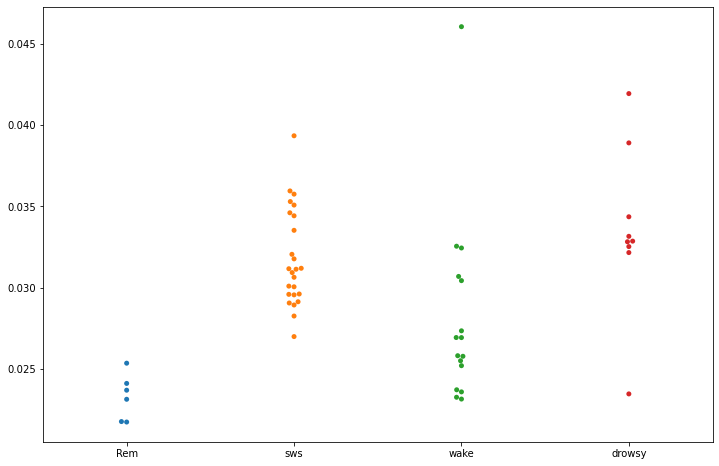

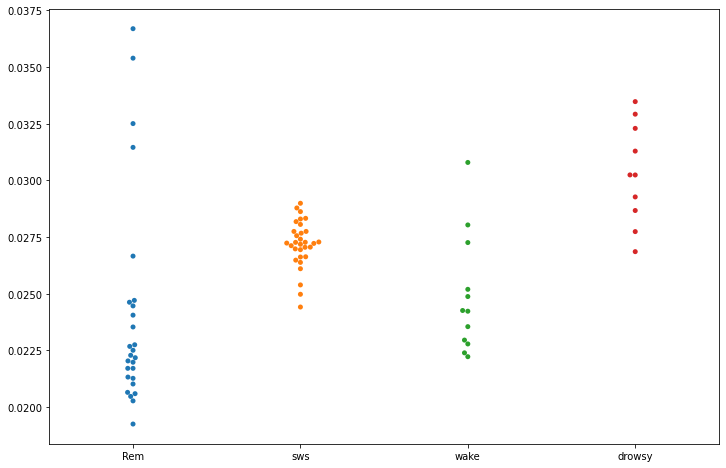

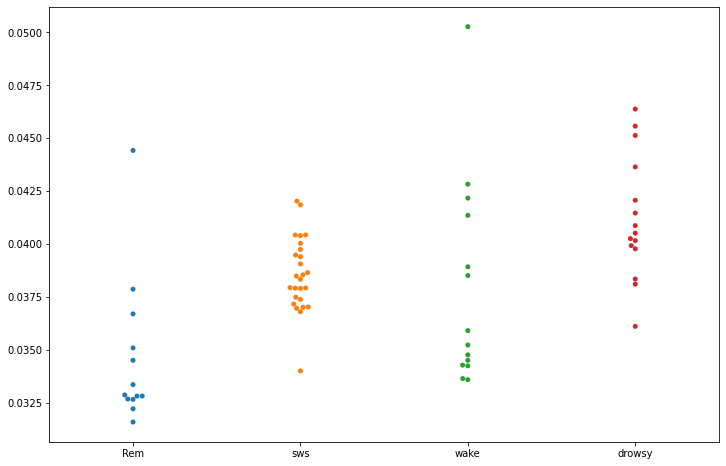

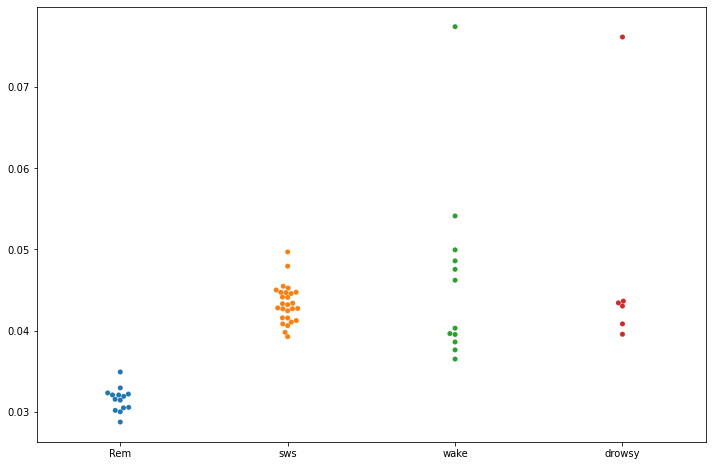

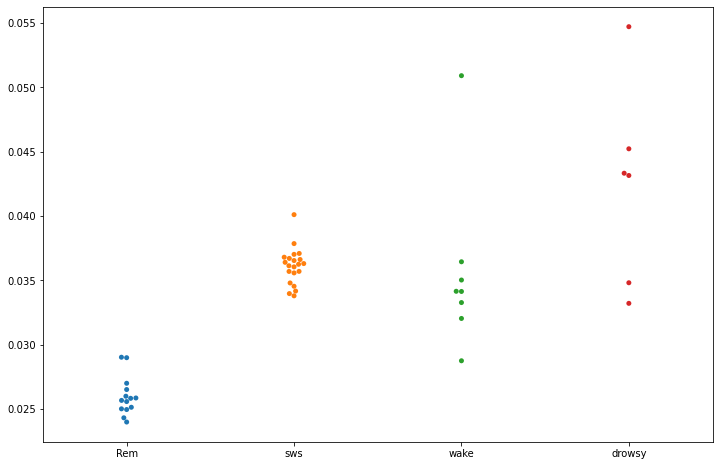

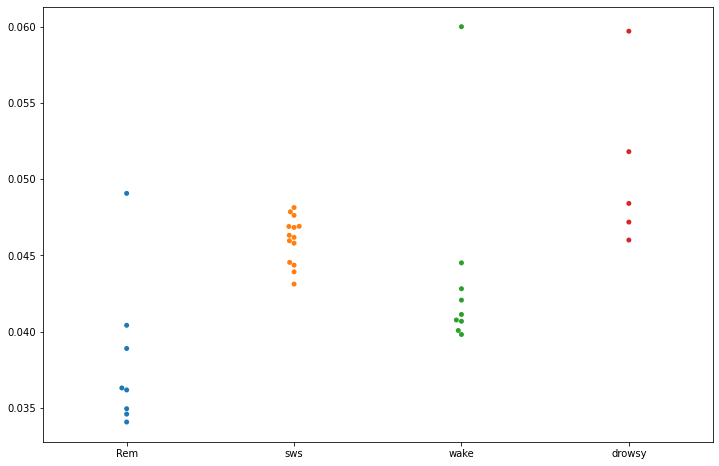

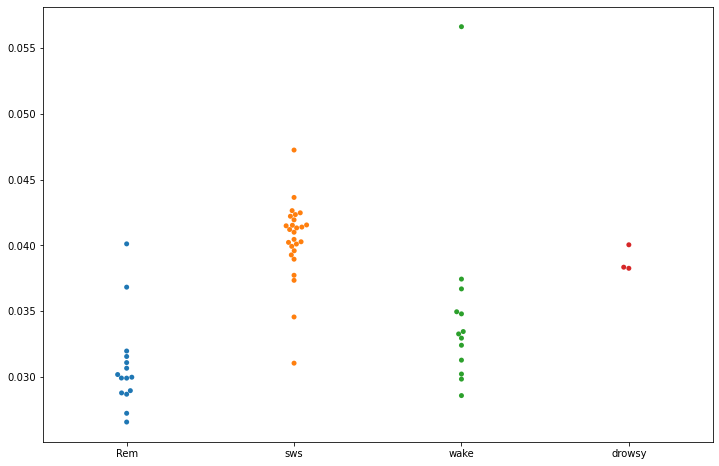

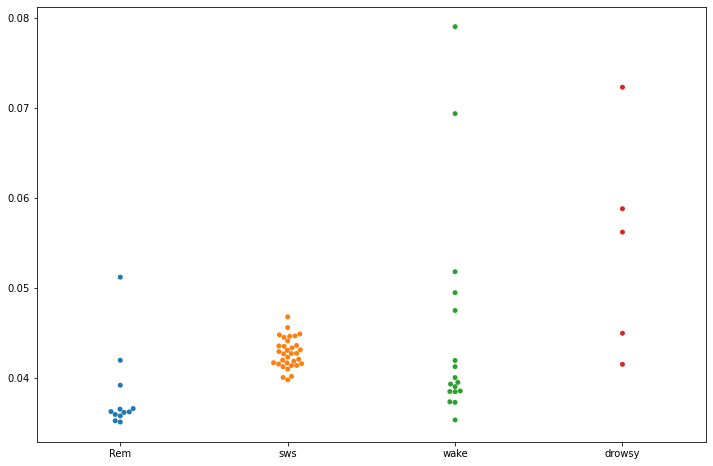

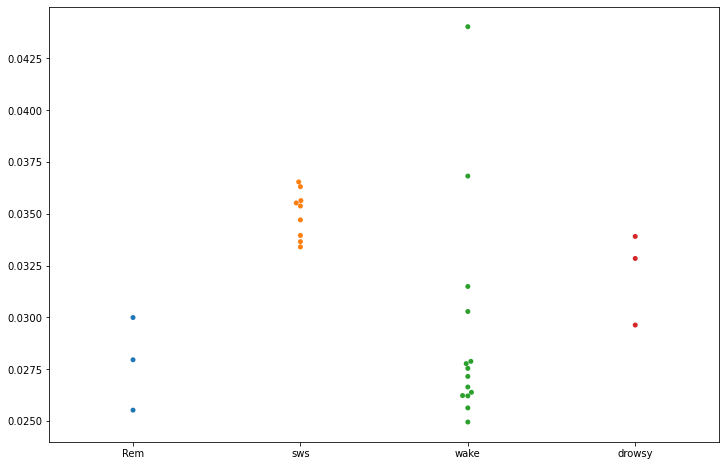

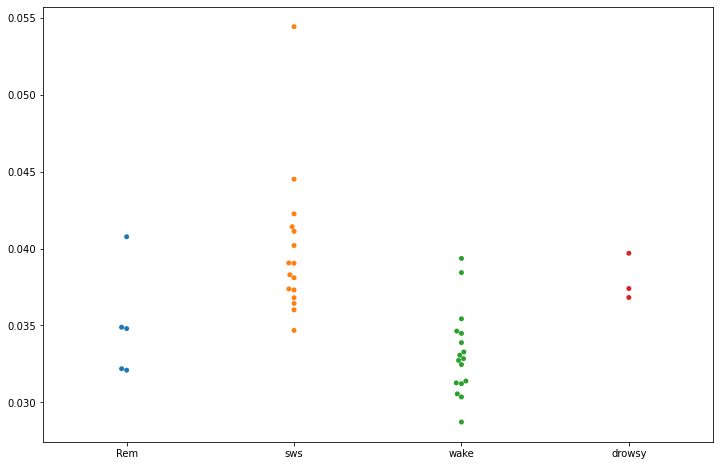

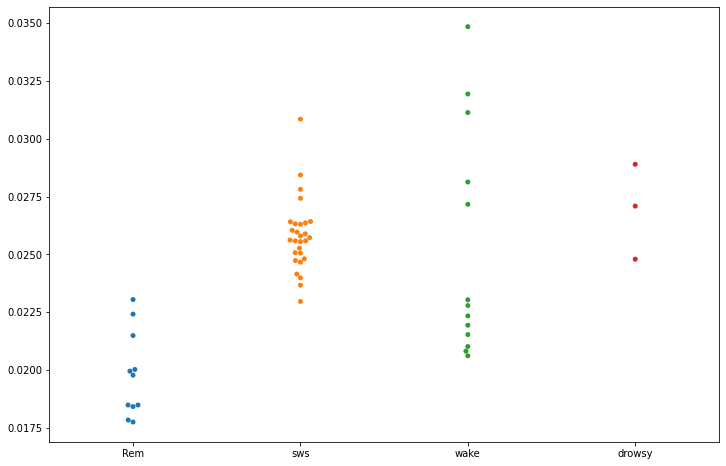

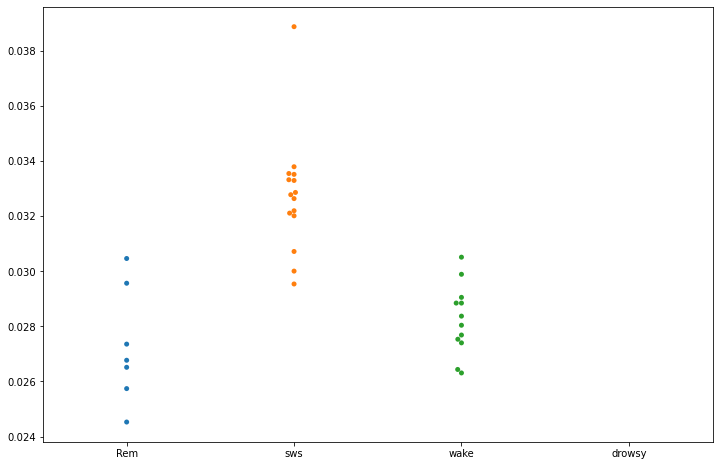

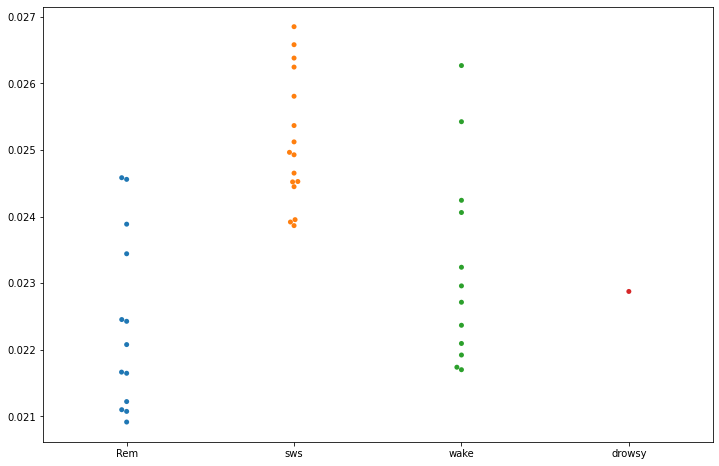

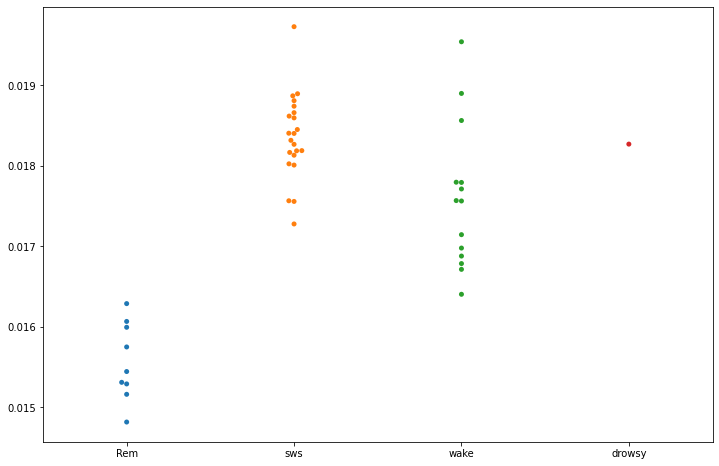

In [6]:
args = ['Hpc',0.025,30]
# state_sync = main('/home/billel/Data/GG-Dataset/','Rat08/Rat08-20130713',*args)
batch_25ms = bk.load.batch(main,*args)


In [7]:
args = ['Hpc',0.100,30]
# state_sync = main('/home/billel/Data/GG-Dataset/','Rat08/Rat08-20130713',*args)
batch_100ms = bk.load.batch(main,*args)

  2%|▏         | 1/61 [00:01<01:06,  1.11s/it]

Loading Data from Rat08-20130709
('Hpc', 0.1, 30)
Rat : 8 on day : 2
Working with session Rat08-20130709 @ /mnt/electrophy/Gabrielle/GG-Dataset/Rat08/Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy
